# 0-Libraries

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from keras.backend import expand_dims
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.constraints import MaxNorm
from keras.layers import Activation, Dense, Conv1D, Flatten, MaxPooling1D, GlobalAveragePooling1D, MaxPooling1D, AveragePooling1D, Dropout, BatchNormalization, SpatialDropout1D

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# 1- Load Data

## From Github

In [ ]:
s_aureus = pd.read_csv('https://media.githubusercontent.com/media/xlopez-ml/DL-AMR/master/datasets/driams_a/s_aureus_driams_a_bin3_2000_20000Da.csv')
s_aureus.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19991,19994,19997,code,species,Oxacillin,Clindamycin,Ceftriaxone,Ciprofloxacin,Fusidic acid
0,951.428571,826.125000,944.857143,898.428571,1007.714286,936.000000,828.571429,812.000000,782.714286,741.625000,...,35.5,20.5,27.342857,029f0abf-1664-424f-88cb-11c9c8af2b11,Staphylococcus aureus,0.0,0.0,0.0,0.0,1.0
1,784.714286,701.125000,681.571429,762.142857,737.571429,733.000000,735.857143,659.571429,802.714286,554.375000,...,30.0,40.5,34.695238,08149af1-10f5-4f02-81d8-3d46d66d4a7a,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
2,50.875000,89.142857,56.142857,151.285714,132.714286,110.428571,47.285714,63.428571,100.375000,52.142857,...,2.5,30.5,11.288462,08fe3876-ecee-4ddc-9aa9-a84f605757f7,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
3,843.285714,816.500000,734.428571,1027.142857,979.428571,875.571429,912.142857,714.428571,945.428571,886.500000,...,15.5,8.0,20.057143,0a9fdd4b-7180-47c0-849e-cb32d46da94c,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,25.5,32.0,24.990476,0d82f4c4-473c-49d8-8c85-e3e36e96d047,Staphylococcus aureus,1.0,0.0,1.0,1.0,0.0


## From Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
s_aureus = pd.read_csv('https://media.githubusercontent.com/media/xlopez-ml/DL-AMR/master/datasets/driams_a/s_aureus_driams_a_bin3_2000_20000Da.csv')
s_aureus.head()

## Upload from local storage

In [ ]:
from google.colab import files
import io

uploaded = files.upload()
dataset = pd.read_csv(io.BytesIO(uploaded['dataset.csv']))
dataset.head()

# Preprocessing Data

In [ ]:
s_aureus.drop(columns=['species','code'], inplace=True) # Eliminamos la columna que contiene un index y que incluye los codigos de los archivos de masas
# Reemplazamos los perfiles de resistencia (variables dependientes) por 0 y 1
#s_aureus.dropna(axis=0, how="any", inplace=True)

In [ ]:
s_aureus_ceftriaxone = s_aureus.drop(columns=['Oxacillin', 'Clindamycin', 'Ceftriaxone', 'Fusidic acid'])
#ceftriaxone.dropna(axis=0, how="any", inplace=True)
s_aureus_ceftriaxone.dropna(axis=0, how="any", inplace=True)
s_aureus_ceftriaxone.shape

(3757, 6001)

In [ ]:
s_aureus_ceftriaxone.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19973,19976,19979,19982,19985,19988,19991,19994,19997,Ciprofloxacin
0,951.428571,826.125000,944.857143,898.428571,1007.714286,936.000000,828.571429,812.000000,782.714286,741.625000,...,14.333333,24.0,68.0,19.0,19.000000,50.0,35.5,20.5,27.342857,0.0
1,784.714286,701.125000,681.571429,762.142857,737.571429,733.000000,735.857143,659.571429,802.714286,554.375000,...,15.666667,39.0,19.5,42.0,69.666667,31.0,30.0,40.5,34.695238,0.0
2,50.875000,89.142857,56.142857,151.285714,132.714286,110.428571,47.285714,63.428571,100.375000,52.142857,...,20.666667,17.0,2.0,18.0,18.000000,11.5,2.5,30.5,11.288462,0.0
3,843.285714,816.500000,734.428571,1027.142857,979.428571,875.571429,912.142857,714.428571,945.428571,886.500000,...,22.333333,33.0,29.0,14.5,21.666667,24.5,15.5,8.0,20.057143,0.0
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,26.666667,25.5,18.0,53.5,23.000000,24.5,25.5,32.0,24.990476,1.0


In [ ]:
X = s_aureus_ceftriaxone.iloc[:, 0:6000].values  # variables independientes (espectros de masa)
y = s_aureus_ceftriaxone.iloc[:, 6000].values    # variable dependientes (resistencia a ciprofloxacin)
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)

In [ ]:
X_train, X_test, y_train, y_test_ciprofloxacin = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

In [ ]:
scaler=Normalizer(norm='max')
sc_X = scaler
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [ ]:
sample_size = X_train.shape[0] # numero de muestras en el set de datos
time_steps  = X_train.shape[1] # numero de atributos en el set de datos
input_dimension = 1            #

X_train_reshaped = X_train.reshape(sample_size,time_steps,input_dimension)
X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001)
early_st = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

n_timesteps = X_train_reshaped.shape[1] #
n_features  = X_train_reshaped.shape[2] #

# Create and fit DeepAMR model

In [ ]:
model = Sequential(name="Modelo_s_aureus_ciprofloxacin")
init_mode = 'normal'
model.add(Conv1D(filters=(64), kernel_size=(16), input_shape = (n_timesteps,n_features), name='Conv_1'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D"))

model.add(Conv1D(filters=(128), kernel_size=(8),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name='Conv_2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D1"))

model.add(Conv1D(filters=(256), kernel_size=(4),kernel_initializer=init_mode,kernel_regularizer=regularizers.l2(0.0001),   name='Conv_3'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D2"))

model.add(Conv1D(filters=(256), kernel_size=(2),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),   name='Conv_3l'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D2dl"))

model.add(Flatten())
model.add(Dropout(0.65))
model.add(Dense(256, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_0"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_1"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name="fully_connected_2"))
model.add(Dense(n_features, activation='sigmoid', name="OUT_Layer"))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy',  metrics=METRICS)
model.summary()

Model: "Modelo_s_aureus_ciprofloxacin"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv1D)             (None, 5984, 64)          1152      
                                                                 
 batch_normalization_4 (Batc  (None, 5984, 64)         256       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 5984, 64)          0         
                                                                 
 MaxPooling1D (MaxPooling1D)  (None, 2992, 64)         0         
                                                                 
 Conv_2 (Conv1D)             (None, 2984, 128)         73856     
                                                                 
 batch_normalization_5 (Batc  (None, 2984, 128)        512       
 hNormalization)                     

In [ ]:
history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=10, verbose=1, validation_split=0.1, callbacks=[reduce_lr,early_st])


Epoch 1/100
271/271 [==============================] - 16s 49ms/step - loss: 6.2075 - tp: 17.0000 - fp: 60.0000 - tn: 2191.0000 - fn: 436.0000 - accuracy: 0.8166 - precision: 0.2208 - recall: 0.0375 - auc: 0.5269 - prc: 0.1804 - val_loss: 5.7579 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 261.0000 - val_fn: 40.0000 - val_accuracy: 0.8671 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5274 - val_prc: 0.1442 - lr: 1.0000e-04
Epoch 2/100
271/271 [==============================] - 11s 42ms/step - loss: 5.4723 - tp: 3.0000 - fp: 8.0000 - tn: 2243.0000 - fn: 450.0000 - accuracy: 0.8306 - precision: 0.2727 - recall: 0.0066 - auc: 0.5638 - prc: 0.1974 - val_loss: 5.2145 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 261.0000 - val_fn: 40.0000 - val_accuracy: 0.8671 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6211 - val_prc: 0.2327 - lr: 1.0000e-04
Epoch 3/100
271/271 [==============================] - 11s 42ms/step - loss: 5.0024 - tp: 0.00

# Evaluate the model 

In [ ]:
y_pred  = model.predict(X_test_reshaped)
y_pred = (y_pred>0.5)
cm = confusion_matrix(y_test_ciprofloxacin, y_pred)
print(cm)

24/24 [==============================] - 1s 24ms/step
[[619  10]
 [ 83  40]]


In [ ]:
#print("MCC s_aureus ciprofloxacin:",matthews_corrcoef(y_test_ciprofloxacin, y_pred))

target_names=["0","1"]
print(classification_report(y_test_ciprofloxacin, y_pred, target_names=target_names))

train_predictions_baseline = model.predict(X_train_reshaped, batch_size=10)
test_predictions_baseline = model.predict(X_test_reshaped, batch_size=10)

baseline_results = model.evaluate(X_test_reshaped, y_test_ciprofloxacin, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       629
           1       0.80      0.33      0.46       123

    accuracy                           0.88       752
   macro avg       0.84      0.65      0.70       752
weighted avg       0.87      0.88      0.85       752

76/76 [==============================] - 1s 8ms/step
loss :  0.7742421627044678
tp :  40.0
fp :  10.0
tn :  619.0
fn :  83.0
accuracy :  0.876329779624939
precision :  0.800000011920929
recall :  0.3252032399177551
auc :  0.8212222456932068
prc :  0.6316238641738892



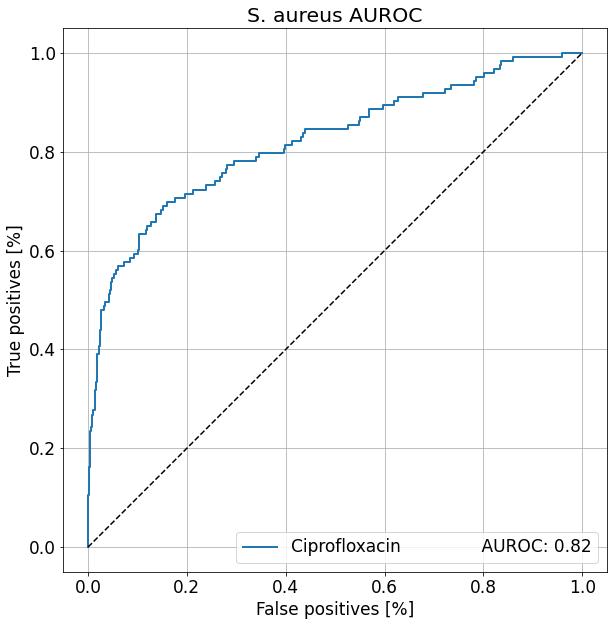

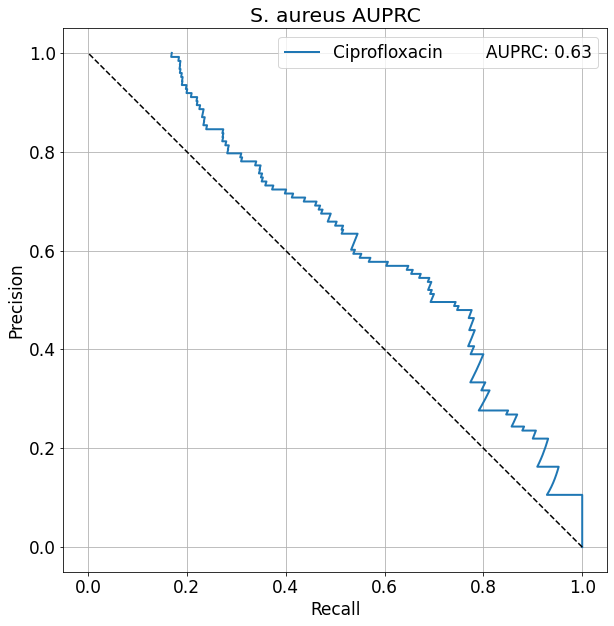

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
mpl.rcParams.update({'font.size': 17})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.title('E. coli CNN')
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.title('S. aureus AUROC')

  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
plot_roc("Ciprofloxacin               AUROC: %0.2f" % baseline_results[8], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='lower right')
plt.savefig('s_aureus_auroc.png', bbox_inches='tight')
plt.show()

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.title('S. aureus AUPRC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot([1, 0], [0, 1], 'k--')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Ciprofloxacin        AUPRC: %0.2f" % baseline_results[9], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='upper right')
plt.savefig('s_aureus_auprc.png', bbox_inches='tight')
plt.show()

In [ ]:
#